JPAの制御をするDC SQUIDの磁束をDCで制御するプログラムです．

事前にやっておくこと

・Anritsu立ち上げておくこと

・制限電圧のセル起動(制限電圧の数値出力されるまで何回かセル試行) → NF エラー → 出力電圧高すぎる
    
    → 速やかにLOCALボタン押してＶ1 OUTPUT OFF

NF コマンドスペース”入れないこと”

OK dcv.send(str.encode("VLT 1,0.0\n"))

NG dcv.send(str.encode("VLT 1, 0.0\n"))

→ Syntax errorがNFに表示される

In [1]:
"""ライブラリインポート"""
import socket
import time
import datetime
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from VaunixLDA133.VaunixLDA133 import VaunixLDA133

In [2]:
'''NF Low Noise DC Voltage'''
#通信パラメータ（いじらなくてよい）
dcv_ip = "192.168.1.252" #IPアドレス(NFのinterfaceから確認できる)
dcv_send_port=10001
dcv_recv_port=4096

# 機器と接続
dcv = socket.socket(socket.AF_INET, socket.SOCK_STREAM)
dcv.connect((dcv_ip, dcv_send_port))


In [3]:
# 制限電圧かける
lmv = str(+0.50)
dcv.send(str.encode(f"LMV 1," + lmv + "\n"))
time.sleep(2)
dcv.send(str.encode(f"LMV? 1\n"))
reply = dcv.recv(dcv_recv_port)
reply = reply.decode("utf-8")
print(reply)

0.5000



In [4]:
dcv.send(str.encode("VLT 1,0.0\n"))
dcv.send(str.encode("VLT? 1\n"))
reply = dcv.recv(dcv_recv_port)
reply = reply.decode("utf-8")
print("DCV : ",reply + "V")

DCV :  0.V


In [8]:
'''Anritsuネトアナ(MS46122B)'''
#通信パラメータ（いじらなくてよい）
# ip = "172.19.96.1" #IPアドレス(Anritsuのソフトウェアから確認できる)
ip = "192.168.1.74" #IPアドレス(Anritsuのソフトウェアから確認できる)
send_port = 5001 #ソケットを送信するポート番号
recv_port = 2056 #ソケットを受信するポート番号

#VNAのパラメータ（4つの読み出し共振周波数をカバーするように帯域を選択する）
na_start_freq = 8.5E9 #Network analyzer sweep start frequency (Hz)
na_end_freq = 11E9   #Network analyzer sweep end frequency (Hz)
na_span_freq = na_end_freq - na_start_freq #Sweep frequency span
na_power = "LOW" #Output power (LOW or High)
na_point = 2001   #Number of measurement points
na_ifbw = 10     #IFBW (Hz)
na_avg = 10      #Average (set from 1 to 1024)
na_avg_switch = "OFF"  #Average switch (ON or OFF)
na_phase_offset = 190  #Phase offset (degrees)
na_sweep_mode = "SING" #Number of sweeps
na_distance = 6.3

start_freq = str(na_start_freq / 1E9)
end_freq = str(na_end_freq / 1E9)

#その他
sleep_time = 240 #freq start~endとpointによる(IFBW:10Hz, point:2001, avg:off)

0000

Attenuation :  5.0 dB
DCV :  1
V
Attenuation :  5.0 dB
DCV :  0.2100
V
Attenuation :  5.0 dB
DCV :  0.2110
V
Attenuation :  5.0 dB
DCV :  0.2120
V
Attenuation :  5.0 dB
DCV :  0.2130
V
Attenuation :  5.0 dB
DCV :  0.2140
V
Attenuation :  5.0 dB
DCV :  0.2150
V
Attenuation :  5.0 dB
DCV :  0.2160
V
Attenuation :  5.0 dB
DCV :  0.2170
V
Attenuation :  5.0 dB
DCV :  0.2180
V
Attenuation :  5.0 dB
DCV :  0.2190
V
Attenuation :  5.0 dB
DCV :  0.2200
V
Attenuation :  5.0 dB
DCV :  0.2210
V
Attenuation :  5.0 dB
DCV :  0.2220
V
Attenuation :  5.0 dB
DCV :  0.2230
V
Attenuation :  5.0 dB
DCV :  0.2240
V
Attenuation :  5.0 dB
DCV :  0.2250
V
Attenuation :  5.0 dB
DCV :  0.2260
V
Attenuation :  5.0 dB
DCV :  0.2270
V
Attenuation :  5.0 dB
DCV :  0.2280
V
Attenuation :  5.0 dB
DCV :  0.2290
V
Attenuation :  5.0 dB
DCV :  0.2300
V
Attenuation :  5.0 dB
DCV :  0.2310
V
Attenuation :  5.0 dB
DCV :  0.2320
V
Attenuation :  5.0 dB
DCV :  0.2330
V
Attenuation :  5.0 dB
DCV :  0.2340
V
Attenuation

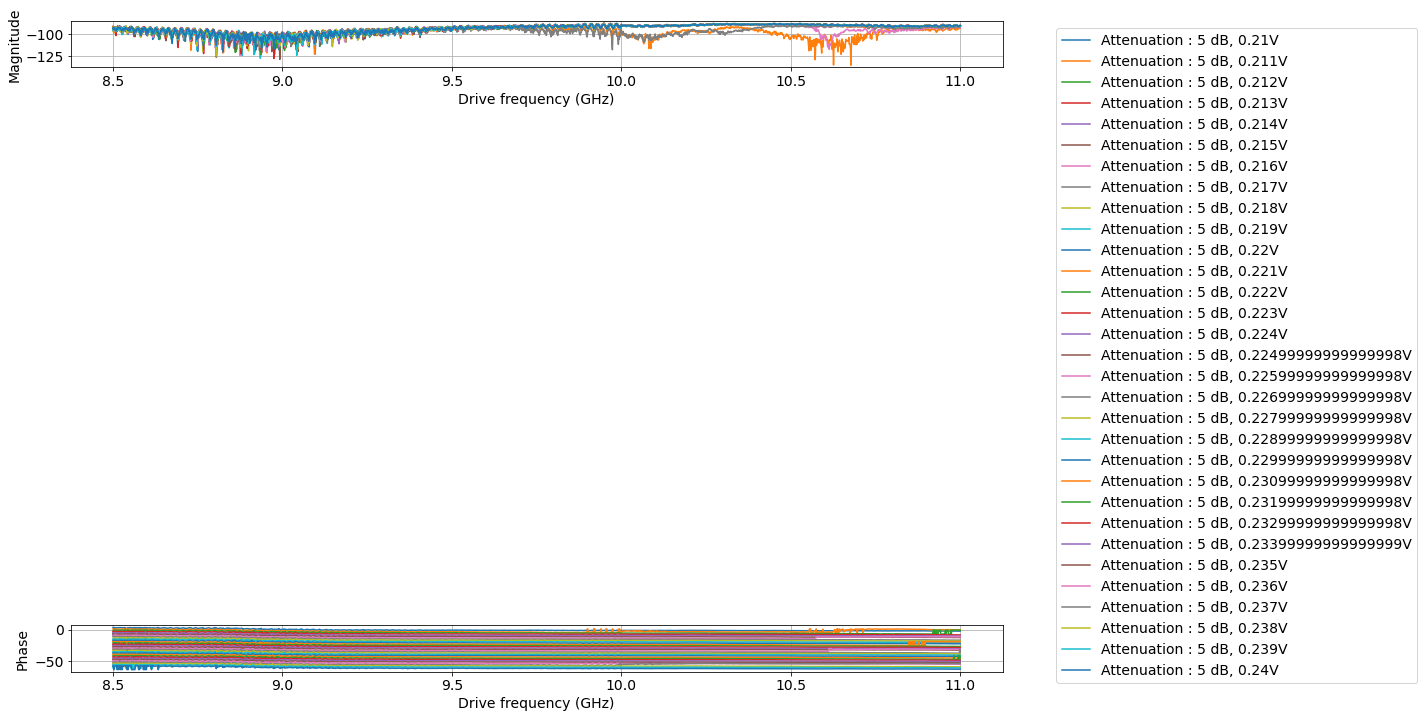

In [9]:
"""機器のパラメータ"""


'''Vaunix 可変アテネータ(LDA-133)'''
#通信パラメータ
serial_number = 28429

#ATTのパラメータ
att = 5 #dB
aTT = str(att)


# DCのパラメータ
min_V = 0.210
max_V = 0.240
num_V = 31
minV = str(min_V)
maxV = str(max_V)
numV = str(num_V)
vlt = np.linspace(min_V, max_V, num_V)

"""機器と接続"""
'''Anritsu ネトアナ'''
vna = socket.socket(socket.AF_INET, socket.SOCK_STREAM)
vna.connect((ip, send_port))

'''Vaunix 可変アテネータ'''
vaunix_lda133 = VaunixLDA133(
    serial_number
)

"""接続確認"""
dcv.send(str.encode("OUT 1,1\n"))
time.sleep(2)
dcv.send(str.encode("OUT? 1\n"))
reply = dcv.recv(dcv_recv_port)
reply = reply.decode("utf-8")
print(reply)


"""キャリブレーション"""
vna.send(str.encode("SENS1:CORR:COEF:CAL:FILE 'G:\マイドライブ\RyoyaOhashi\SetupFile#1.chx'"))

"""グラフの定義"""
plt.rcParams["font.size"] = 14 #まとめてフォントサイズを変える
fig = plt.figure(figsize=(20,10))
ax1 = plt.subplot(2, 1, 1)
ax2 = plt.subplot(2, 1, 2)

"""保存先のパス"""
now = datetime.datetime.now()
foldername = now.strftime(f'%Y%m%d_%H%M%S_') +  aTT + "dB_" + minV + "-" + maxV + "V_" + start_freq + "-"  + end_freq
result_path = "C:/Users/super/Desktop/RyoyaOhashi_C/{0}".format(
    foldername
) # 実験結果の保存場所        
os.makedirs(result_path, exist_ok=True)


"""NFをfor文回す"""
x=0
freq={}
mag={}
phase_deg={}
phase_rad={}
for vlt_x in vlt:
    '''Anritsu ネトアナ パラメータ設定'''
    vna.send(str.encode(f"SENS:FREQ:SPAN {na_span_freq}\n"))  #スイープ範囲の設定
    vna.send(str.encode(f"SENS:FREQ:STAR {na_start_freq}\n")) #スイープする周波数帯域の開始周波数を設定
    vna.send(str.encode(f"SENS:FREQ:STOP {na_end_freq}\n"))   #スイープする周波数帯域の終了周波数を設定
    vna.send(str.encode(f"SOUR:POW {na_power}\n"))            #パワー
    vna.send(str.encode(f"SENS:SWEEP:POINT {na_point}\n"))    #測定ポイント数
    vna.send(str.encode(f"SENS:BAND {na_ifbw}\n"))            #IFBW
    vna.send(str.encode(f"SENS:AVER:COUN {na_avg}\n"))        #Average
    vna.send(str.encode(f"SENS:AVER {na_avg_switch}\n"))      #AverageのON OFF
    vna.send(str.encode(f"CALC:REF:EXT:PORT1:PHA {na_phase_offset}\n")) #Phase Offset
    vna.send(str.encode(f"SENS:HOLD:FUNC {na_sweep_mode}\n")) #スイープモードの設定
    vna.send(str.encode(f"CALC1:REF:EXT:PORT1:DIST {na_distance}\n")) #Distance設定

    '''Vaunix 可変アテネータ パラメータ設定'''
    vaunix_lda133.set_att(att)
    print("Attenuation : ", vaunix_lda133.get_att(), "dB")

    '''NF Low Noise DC Voltage パラメータ設定'''
    v = str(vlt_x)
    dcv.send(str.encode(f"VLT 1," + v + "\n"))
    dcv.send(str.encode(f"VLT? 1\n"))
    reply = dcv.recv(dcv_recv_port)
    reply = reply.decode("utf-8")
    print("DCV : ",reply + "V")
    time.sleep(sleep_time) #スイープ終わるまで待つ

    """データ取得"""
    filename = now.strftime(f'%Y%m%d_%H%M%S_') + aTT + "dB_" + v + 'V' + '.csv'
    csvname = "C:/Users/super/Desktop/RyoyaOhashi_C/" + foldername + "/" + filename
    vna.send(str.encode(f'MMEM:STOR "C:/Users/super/Desktop/RyoyaOhashi_C/{foldername}/{filename}"\n')) #Gドライブは保存できないので，Cドライブ(ローカル)に保存する
    # vna.send(str.encode(f'MMEM:STOR' + csvname + '\n')) #Gドライブは保存できないので，Cドライブ(ローカル)に保存する
   
    """データの描画"""
    #測定データの読み込み
    time.sleep(10.0) #データが保存される前に読み込むとエラーになる．
    # csvname = f"C:/Users/super/Desktop/RyoyaOhashi_C/" + foldername + "/" + filename
    freq[vlt_x], mag[vlt_x], phase_deg[vlt_x] = np.loadtxt(csvname, skiprows=17, usecols=[1, 2, 3], delimiter=',', unpack=True)
    phase_rad[vlt_x] = phase_deg[vlt_x] * np.pi / 180

    # これをカラム名にする
    col_names = ('A', 'B', 'C', 'D')
    df = pd.read_csv(csvname, sep=',',  names=col_names, usecols=[0,1,2,3])
    df_AB = pd.DataFrame({
    'A':['ATT', 'minV', 'maxV', 'numV'], 
    'B':[att, minV, maxV, numV]
    })
    df_C = pd.concat([df, df_AB], axis = 1)
    df_C.to_csv(csvname, header=False, index=False)
    # print(df_C)
    #測定データのプロット
    ax1.plot(freq[vlt_x], mag[vlt_x], label = f"Attenuation : {att} dB, " + v + 'V' )
    ax2.plot(freq[vlt_x], phase_rad[vlt_x] -2*x , label = f"Attenuation : {att} dB, " + v + 'V')
    x+=1
 
"""機器と切断"""
dcv.send(str.encode("OUT 1,0\n"))
dcv.send(str.encode("OUT? 1\n"))
reply = dcv.recv(recv_port)
reply = reply.decode("utf-8")
print(reply)

"""電圧0に"""
dcv.send(str.encode("VLT 1,0.0\n"))
dcv.send(str.encode("VLT? 1\n"))
reply = dcv.recv(dcv_recv_port)
reply = reply.decode("utf-8")
print("DCV : ",reply + "V")

"""データ出力"""
ax1.set_xlabel("Drive frequency (GHz)")
ax1.set_ylabel("Magnitude")
ax1.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left') 
plt.tight_layout()
ax1.grid()

ax2.set_xlabel("Drive frequency (GHz)")
ax2.set_ylabel("Phase")
ax1.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left') 
plt.tight_layout()
ax2.grid()

中断した時用に電圧0にする

In [11]:
"""機器と切断"""
dcv.send(str.encode("OUT 1,0\n"))
dcv.send(str.encode("OUT? 1\n"))
reply = dcv.recv(recv_port)
reply = reply.decode("utf-8")
print(reply)

0.0000



In [12]:
dcv.send(str.encode("VLT 1,0.0\n"))
dcv.send(str.encode("VLT? 1\n"))
reply = dcv.recv(dcv_recv_port)
reply = reply.decode("utf-8")
print("DCV : ",reply + "V")

DCV :  0
V
